Below are the exprimental results from running the sysbench benchmark to reproduce the results in the paper - to show the benifit of TPT for memory accesses. 
The key observation is that TPT is benifitial for programs with random memory accesses with large buffer size. 
This was for time limited run of sysbench running for 10 seconds with the buffer size of 4GB, aiming to transfer 100G of data for "read" operations. 

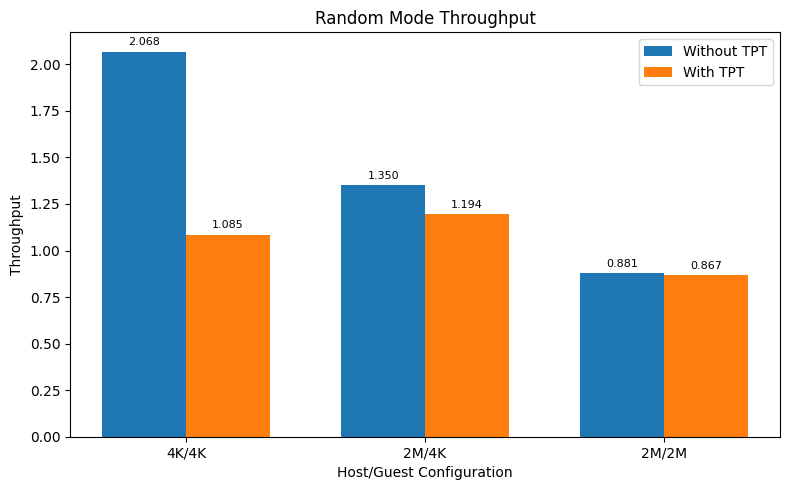

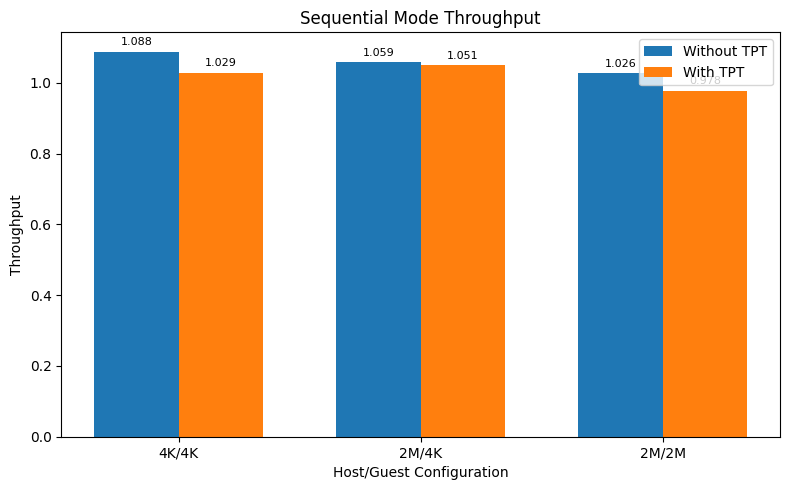

In [2]:
import numpy as np
import matplotlib.pyplot as plt

RANDOM_NATIVE = 328.203
SEQUENTIAL_NATIVE = 9454.887

def plot_throughput(data_without, data_with, mode, group_labels, fmt='.1f'):
    n_groups = len(group_labels)
    index = np.arange(n_groups)
    bar_width = 0.35

    plt.figure(figsize=(8, 5))
    bars1 = plt.bar(index - bar_width/2, data_without, bar_width, label='Without TPT', color='#1f77b4')
    bars2 = plt.bar(index + bar_width/2, data_with, bar_width, label='With TPT', color='#ff7f0e')

    plt.xlabel('Host/Guest Configuration')
    plt.ylabel('Throughput')
    plt.title(f'{mode} Mode Throughput')
    plt.xticks(index, group_labels)
    plt.legend()

    # Function to add labels with specified format
    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.annotate(f'{height:{fmt}}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

    add_labels(bars1)
    add_labels(bars2)

    plt.tight_layout()
    plt.show()

# Data for random mode (values in IOPS)
random_without = [158.685, 243.09, 372.582]
random_with = [302.41, 274.843, 378.718]
group_labels = ['4K/4K', '2M/4K', '2M/2M']
normilized_random_without = [RANDOM_NATIVE / x for x in random_without]
normilized_random_with = [RANDOM_NATIVE / x for x in random_with]
plot_throughput(normilized_random_without, normilized_random_with, 'Random', group_labels, fmt='.3f')

# Data for sequential mode (values in IOPS)
sequential_without = [8689.182, 8926.269, 9213.024]
sequential_with = [9191.347, 8997.371, 9668.146]
normilized_sequential_without = [SEQUENTIAL_NATIVE / x for x in sequential_without]
normilized_sequential_with = [SEQUENTIAL_NATIVE / x for x in sequential_with]
plot_throughput(normilized_sequential_without, normilized_sequential_with, 'Sequential', group_labels, fmt='.3f')


Below are the plots/results for running the sysbench for different buffer sizes for random memory accesses. 
From now, we will focus on with the config of 4K/4K page sizes for the guest and host since it is the config where we see a massive diffence in with/without TPT enabled from the above graph. 
Now, the following expriments are carried out to determine the buffer size (RSS value - working memory size) to understand the benifit of TPT for large buffer sizes compared with small buffer sizes. 
On a TLB miss, for the address translation - we perform a page walk, for which, the address could be cached at multiples levels of the page walk with the PWC. The 3 levels of PWC on intel are the PDE Cache, PDEPT cache, PML4E cache. For a given program, we would always get an hit on the PML4E cache (1 entry) because its coverage is 512GB for an entry which is not a feesable RSS value - run out of memory. For the next level cache, PDPTE cache (4 entries), each entry has a coverage of 1GB. Hence, if our buffer size is larger than 4GB, we might not always get an hit on this cache, which slowes down the process of address translation, since we need to perform page walk from this point. 
Below are the experiement results for different buffer sizes. 
 

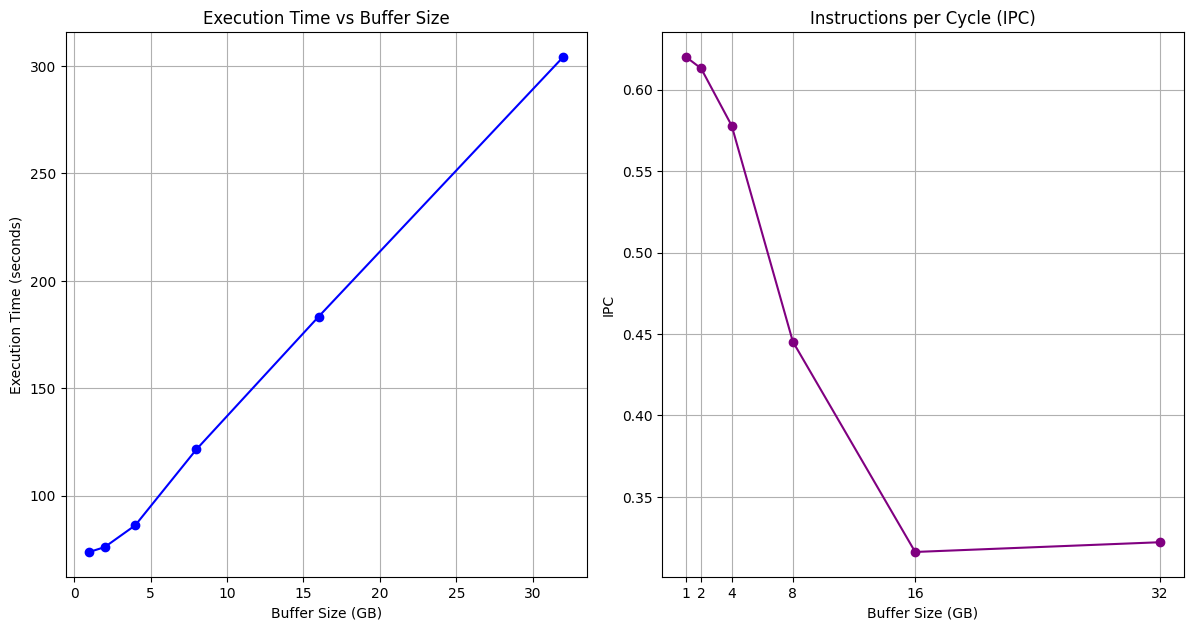

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Dataset
data = {
    'BufferSize': [1, 2, 4, 8, 16, 32],
    'Cycles': [221234815802, 227998269269, 258437982755, 364458304277, 550039185092, 912763679945],
    'Instructions': [137187830036, 139751224994, 149336591817, 162295945232, 173952578580, 294117657652],
    'dTLB-load-misses': [4318195319, 4340523334, 4441785285, 5457412244, 7139757142, 8310290514],
    'dtlb_load_misses.miss_causes_a_walk': [4318679689, 4340430899, 4405211266, 5388448300, 7217869168, 8211362356],
    'dtlb_load_misses.stlb_hit': [105479507, 137527626, 121680939, 289005879, 953742789, 1921976911],
    'dtlb_load_misses.walk_completed': [4314150637, 4335160794, 4400046706, 5374130475, 7169247787, 8096988994],
    'dtlb_load_misses.walk_duration': [235240781486, 245789108605, 265289136106, 431358368054, 664576252440, 1108958080546],
}

# Create DataFrame
df = pd.DataFrame(data)

clock_speed = 3 * 10**9  # 3 GHz

# Normalize metrics
df['IPC'] = df['Instructions'] / df['Cycles']
df['CPU_Cycles'] = df['Instructions'] / df['IPC']
df['Execution_Time'] = df['CPU_Cycles'] / clock_speed  # in seconds

# Plotting
plt.figure(figsize=(18, 12))

# Execution Time Plot
# As the buffer size increases, the execution time should increase.
# This is because the CPU is stalled waiting for address translation. 

plt.subplot(2, 3, 1)
plt.plot(df['BufferSize'], df['Execution_Time'], marker='o', color='blue')
plt.title('Execution Time vs Buffer Size')
plt.xlabel('Buffer Size (GB)')
plt.ylabel('Execution Time (seconds)')
plt.grid(True)

# Instructions per Cycle (IPC) 
# as the buffer size increases, the IPC should decrease
# this is becuase the CPU is stalled (waiting) for the address translation due to increased TLB misses, which cause page walks which caues a bottlenck in performance. 
# PWC hits become less likely as buffer size increases (greater than 4GB) and the CPU is stalled waiting for the page walk to complete.
plt.subplot(2, 3, 2)
plt.plot(df['BufferSize'], df['IPC'], marker='o', color='purple')
plt.title('Instructions per Cycle (IPC)')
plt.xlabel('Buffer Size (GB)')
plt.ylabel('IPC')
plt.grid(True)




# Only label the given buffer sizes
plt.xticks(df['BufferSize'])  

plt.tight_layout()
plt.show()


In [9]:
import pandas as pd

def load_data(file_path):
    """
    Load CSV data into a pandas dataframe.
    """
    return pd.read_csv(file_path)

def compute_metrics(df):
    """
    Normalize the data by extracting the buffer size and calculating the 
    required miss and ratio metrics.
    """
    # Extract buffer size from the command string (in GB)
    df['buffer_size_gb'] = df['command'].str.extract(r'block-size=(\d+)G').astype(int)

    # Calculate load and store misses per GB (normalized)
    df['load_misses_per_GB'] = df['dTLB-load-misses'] / df['buffer_size_gb']
    df['store_misses_per_GB'] = df['dTLB-store-misses'] / df['buffer_size_gb']
    
    # calculate loads and stores per GB (normalized)
    df['loads_per_GB'] = df['dTLB-loads'] / df['buffer_size_gb']
    df['stores_per_GB'] = df['dTLB-stores'] / df['buffer_size_gb']
    
    # compute ratios 
    df['dTLB_load_miss_ratio'] = df['load_misses_per_GB'] / df['loads_per_GB']
    df['dTLB_store_miss_ratio'] = df['store_misses_per_GB'] / df['stores_per_GB']
    
    df['dTLB_miss_ratio'] = (df['load_misses_per_GB'] + df['store_misses_per_GB']) / (df['loads_per_GB'] + df['stores_per_GB'])
    
    # ept walk cycles ratio -> greater of this - more cycles are spent on ept walk (TPT should be enabled)
    df['ept_walk_cycles_ratio'] = df['ept.walk_cycles'] / df['cycles']
    
    return df

def clean_command_column(df):
    """
    Clean the command column by removing access mode part (seq/rnd).
    """
    df.loc[:, 'command'] = df['command'].str.replace(' access-mode=seq', '', regex=False)
    df.loc[:, 'command'] = df['command'].str.replace(' access-mode=rnd', '', regex=False)
    return df

def analyze_data(df):
    """
    Perform analysis by splitting data into sequential and random access modes.
    """
    # Split by access mode
    df_seq = df[df['command'].str.contains('access-mode=seq')]
    df_rnd = df[df['command'].str.contains('access-mode=rnd')]
    
    # Clean command column
    df_seq = clean_command_column(df_seq)
    df_rnd = clean_command_column(df_rnd)

    # Display results
    print("Sequential Mode:")
    print(df_seq[['command', 'dTLB_load_miss_ratio', 'dTLB_store_miss_ratio', 'ept_walk_cycles_ratio']])
    
    print("\nRandom Mode:")
    print(df_rnd[['command', 'dTLB_load_miss_ratio', 'dTLB_store_miss_ratio','ept_walk_cycles_ratio']])

def compare_performance(df_no_tpt, df_tpt):
    """
    Compare performance between TPT enabled and TPT disabled datasets.
    """
    # Normalize both datasets
    df_no_tpt = compute_metrics(df_no_tpt)
    df_tpt = compute_metrics(df_tpt)
    
    # Analyze both datasets
    print("====== Without TPT ======")
    analyze_data(df_no_tpt)
    
    print("\n\n====== With TPT ======")
    analyze_data(df_tpt)

# Load the data
df_no_tpt = load_data('sysbench_memory_final_no_tpt.csv')
df_tpt = load_data('sysbench_memory_final_tpt.csv')

# Compare performance
compare_performance(df_no_tpt, df_tpt)


====== Without TPT ======
Sequential Mode:
                    command  dTLB_load_miss_ratio  dTLB_store_miss_ratio  \
0   block-size=8G oper=read              0.006323               0.102777   
2  block-size=8G oper=write              1.055247               0.011568   
4   block-size=1G oper=read              0.002464               0.076011   
6  block-size=1G oper=write              0.390441               0.005645   

   ept_walk_cycles_ratio  
0               0.032266  
2               0.030176  
4               0.017214  
6               0.026670  

Random Mode:
                    command  dTLB_load_miss_ratio  dTLB_store_miss_ratio  \
1   block-size=8G oper=read              0.921553               0.003545   
3  block-size=8G oper=write              0.000961               1.480467   
5   block-size=1G oper=read              0.590349               0.000451   
7  block-size=1G oper=write              0.000356               1.016574   

   ept_walk_cycles_ratio  
1               1.0

The below does clustering on all the available features to determine to enable/not-enable TPT. This clustering uses K-Means to differentiate between 2 of these groups (enable/non-enable TPT). 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def cluster_performance(df):
    """
    Cluster the performance data to identify patterns for TPT benefit.
    """
    features = ['dTLB-load-misses', 'dTLB-loads', 'dTLB-store-misses', 'dTLB-stores', 
                'dtlb_load_misses.miss_causes_a_walk', 'dtlb_load_misses.stlb_hit',
                'dtlb_load_misses.walk_completed', 'dtlb_load_misses.walk_duration',
                'dtlb_store_misses.miss_causes_a_walk', 'dtlb_store_misses.stlb_hit', 
                'dtlb_store_misses.walk_completed', 'dtlb_store_misses.walk_duration', 
                'ept.walk_cycles', 'page_walker_loads.dtlb_l1', 'page_walker_loads.dtlb_l2', 
                'page_walker_loads.dtlb_l3', 'page_walker_loads.dtlb_memory', 
                'page-faults', 'major-faults', 'minor-faults', 'dTLB_load_miss_ratio', 
                'dTLB_store_miss_ratio', 'ept_walk_cycles_ratio']
    
    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])
    
    kmeans = KMeans(n_clusters=2, random_state=42) # 2 clusters (TPT/No-TPT)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Analyze the clusters
    for cluster in df['cluster'].unique():
        print(f"\nCluster {cluster}:")
        cluster_data = df[df['cluster'] == cluster]
        print(cluster_data[['command']])
        
# Cluster the 'no_tpt' dataset
cluster_performance(df_no_tpt)



Cluster 0:
                                    command
0   block-size=8G oper=read access-mode=seq
2  block-size=8G oper=write access-mode=seq
4   block-size=1G oper=read access-mode=seq
5   block-size=1G oper=read access-mode=rnd
6  block-size=1G oper=write access-mode=seq

Cluster 1:
                                    command
1   block-size=8G oper=read access-mode=rnd
3  block-size=8G oper=write access-mode=rnd
7  block-size=1G oper=write access-mode=rnd
